In [759]:
%%html
<style>
    .container {
        width: 85% !important;
    }
</style>

In [760]:
import os
import numpy as np
from BCI2000Tools.FileReader import bcistream
from BCI2000Tools.Electrodes import *
from BCI2000Tools.Plotting import *
import mne 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyprep.prep_pipeline import PrepPipeline, NoisyChannels

import eeg_dict # Contains dictionaries and libraries for electrodes locations 
import MotorImageryTools as mi # Contains tools for eeg and motor imagery

import plot_style
plot_style.set_plot_style()

# After changes to the class in test
import importlib
importlib.reload(mi)
importlib.reload(eeg_dict)

#plt.rcParams['font.family'] = ['serif']
#plt.rcParams['font.serif'] = ['Times New Roman']
#plt.rcParams['font.size'] = 12  # You can also set the default font size

<module 'eeg_dict' from '/mnt/c/Users/scana/Dropbox/WCornell/develop/motorimagery/eeg_dict.py'>

In [761]:
EEG = mi.EEG()       # Initialize EEG tools
PLOT = mi.Plotting() # Initialize Plotting tools

In [663]:
file_path = '/mnt/c/Users/scana/Desktop/MI_test/'

if 1: 
    file_name = 'RI21-ses01-motor.dat'
    #file_name = 'RI32-ses01-motor.dat'
    #file_name = 'RI35-ses01-motor.dat'
    #file_name = 'RI47-ses01-motor.dat'
    #file_name = 'RI65-ses01-motor.dat'
    #file_name = 'RI75-ses01-motor.dat'
    #file_name = 'RI76-ses01-motor.dat'
    #file_name = 'RI103-ses01-motor.dat'
    #file_name = 'RI105-ses01-motor.dat'
    #file_name = 'RI115-ses01-motor.dat'
    
if 0: 
    file_name = 'GS4005-ses01-motor.dat'
    
if 0:
    #file_name = 'sub-BIpeds149_ses-42_task-MotorImag_run-01.dat'
    file_name = 'sub-BIpeds166_ses-01_task-MotorImag_run-01.dat'
    #file_name = 'sub-BIpeds166_ses-04_task-MotorImag_run-01.dat'
    #file_name = 'sub-BIpeds173_ses-01_task-MotorImag_run-01.dat'
    

# Handle the input options
clean_bool = True
resolution = 1
secPerSegment = 1/resolution
secOverlap = secPerSegment/2
fmin = 1
fmax = 40
freq_band = [4,8,13,31]

ch_location = eeg_dict.ch_location

# Extract base name from file
base_name, extension = os.path.splitext(file_name)

# Create a folder using base name, if folder doesn't exist 
path_to_folder = EEG.create_folder(path=file_path, folder_name=base_name)

Folder 'RI21-ses01-motor' already exists at /mnt/c/Users/scana/Desktop/MI_test/


In [664]:
# Import .dat file
signal, states, fs, ch_names, blockSize, montage_type = EEG.import_file_dat(file_path, file_name)

if montage_type == 'DSI_24': ch_info = 'DSI24_location.txt'
elif montage_type == 'EGI_128': ch_info = 'EGI128_location.txt'
elif montage_type == 'GTEC_32': ch_info = 'GTEC32_location.txt'


EEG channels: 20 Total ticks: 125400
Each tick corresponds to [s]: 0.0033333333333333335
Sampling rate [Hz]: 300.0 ~~~ Time on file [s]: 418.0
Montage Detected: DSI_24
Signal range: [-9791.0390625, -481.2362976074219, 2824.9404296875]
StimulusCode: (array([0, 1, 2, 3]), array([96600,  7200,  7200, 14400]))



In [665]:
#file_names = ['RI21-ses01-motor.dat',
#              'RI32-ses01-motor.dat',
#              'RI35-ses01-motor.dat',
#              'RI47-ses01-motor.dat',
#              'RI65-ses01-motor.dat',
#              'RI75-ses01-motor.dat',
#              'RI76-ses01-motor.dat',
#              'RI103-ses01-motor.dat',
#              'RI105-ses01-motor.dat',
#              'RI115-ses01-motor.dat']
#for file_name in file_names: 
#    b = bcistream(file_path + file_name)
#    #signal, states = b.decode()
#    print(file_name, b.params['StorageTime'].split('T')[0].split('-'), b.params['StorageTime'].split('T')[1])

In [666]:
fileTime, nBlocks, trialsPerBlock, initialSec, stimSec, taskSec = EEG.evaluate_mi_paradigm(signal=signal, states=states, fs=fs, blockSize=blockSize, verbose=True)
nSplit = 6
rejectSec = taskSec - 9 # 1 [s]

tmin = 0
twindow = (taskSec - rejectSec) # e.g. 9
tmax = twindow/nSplit # e.g. 1.5

Block size [12] fits perfectly in sample frequency [25.0]!
This file contains 100.0% of MI paradigm
    Number of full blocks: 8
    Additional trials: 0.0


In [667]:
# File has not been cleaned before, it's a new file
if not clean_bool:
    ch_set = ChannelSet(ch_info)

    # Create unfiltered RAW for PREP
    RAW = EEG.make_RAW_with_montage(signal=signal * 1e-6, 
                                    fs=fs, 
                                    ch_names=ch_set.get_labels(), 
                                    montage_type=montage_type, 
                                    conv_dict=eeg_dict.stand1020_to_egi)

    # Run PREP for bad channels
    EEG.make_PREP(RAW, isSNR=False, isDeviation=False, isHfNoise=True, isNanFlat=True, isRansac=False)
    
    # Bandpass filter
    signalFilter = EEG.filter_data(signal, fs, l_freq=fmin, h_freq=fmax)

    # Re-reference
    if montage_type == 'EGI_128':
        # Re-reference to mastoids
        signalFilter, ch_set = EEG.spatial_filter(sfilt='REF', 
                                                  ch_set=ch_set, 
                                                  signal=signalFilter, 
                                                  flag_ch='tp9 tp10', 
                                                  verbose=True)
        
    # Plot ChannelSet after potential re-reference
    plt.figure(figsize=(6,6))
    ch_set.plot()
    plt.text(-1.25, 1.05, f'Montage', weight='bold')
    split_text = montage_type.split('_')
    plt.text(-1.25, 0.95, f'{split_text[0]} {split_text[1]} Channels')
    plt.tight_layout()
    plt.show()


    # Create RAW with montage
    RAW = EEG.make_RAW_with_montage(signal=signalFilter * 1e-6, 
                                    fs=fs, 
                                    ch_names=ch_set.get_labels(), 
                                    montage_type=montage_type, 
                                    conv_dict=eeg_dict.stand1020_to_egi)

    # Mark BAD regions
    EEG.mark_BAD_region(RAW, block=True)

In [668]:
# File has not been cleaned before, it's a new file
if not clean_bool:
    # Summary of BAD regions (confirm the marking)
    EEG.evaluate_BAD_region(RAW, max_duration=fileTime)


    # Add Stim to RAW
    EEG.make_RAW_stim(RAW, states)

    # Create annotations
    RAW = EEG.make_annotation_MI(RAW, fs,
                                nBlocks=nBlocks,
                                trialsPerBlock=trialsPerBlock,
                                initialSec=initialSec,
                                stimSec=stimSec,
                                taskSec=taskSec,
                                rejectSec=rejectSec,
                                nSplit=nSplit,
                                fileTime=fileTime)

In [669]:
if clean_bool: 
    # Here we can import a previously saved .fif file
    RAW, montage, fs = EEG.import_file_fif(path=file_path, file_name=base_name + '.fif')
    #RAW.info['ch_names'] = [x.lower() for x in RAW.info['ch_names']]
    ch_set = ChannelSet([x.lower() for x in RAW.info['ch_names'][:RAW.get_data(picks='eeg').shape[0]]])
    # This is manually added here cause when you import a RAW .fif file it doesn't know the location of all EGI channels, it's inconvenient
    if montage_type=='EGI_128':
        ch_set = ChannelSet('EGI128_location.txt')
        # make sure this rereference is the same as the one before saving the RAW .fif, it should be
        m = np.array(ch_set.RerefMatrix('tp9 tp10'))
        # Occurs in place
        ch_set = ch_set.spfilt(m)

Opening raw data file /mnt/c/Users/scana/Desktop/MI_test/RI21-ses01-motor.fif...
    Reading extended channel information
    Range : 0 ... 125399 =      0.000 ...   417.997 secs
Ready.
Reading 0 ... 125399  =      0.000 ...   417.997 secs...


/mnt/c/Users/scana/Dropbox/WCornell/develop/motorimagery/MotorImageryTools.py:246: RuntimeWarning: This filename (/mnt/c/Users/scana/Desktop/MI_test/RI21-ses01-motor.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  RAW = mne.io.read_raw(path + file_name, preload=True)


In [670]:
# RAW is saved without interpolation performed on it, in this way RAW.info['bads'] still contains the identified bad channels
# Interpolate BAD channels
old_ch_bads = RAW.info['bads']
if not RAW.info['bads'] == []:
    old_ch_bads = EEG.interpolate(RAW)
    # Is any channel bad after interpolation? 
    EEG.make_PREP(RAW, isSNR=True, isDeviation=True, isHfNoise=True, isNanFlat=True, isRansac=True)
    print(f"Currently bad channels: {RAW.info['bads']}")
    print(f'Old bad channels: {old_ch_bads}')

#RAW.plot()

In [671]:
# Summary of X region
EEG.evaluate_BAD_region(RAW, 'BAD_region')
EEG.evaluate_BAD_region(RAW, 'right_rest_1')

 --> BAD_region: 9 sections, ~20.8 s [5.0%] --> Bad channels: []
 --> right_rest_1: 6 sections, ~9.0 s [2.2%] --> Bad channels: []


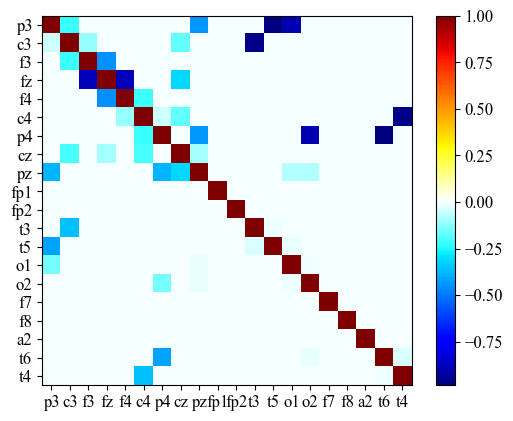

In [672]:
# Spatial filter with exclusion
signalSLAP, ch_setSLAP = EEG.spatial_filter(sfilt   = 'SLAP', 
                                            ch_set  = ch_set, 
                                            signal  = RAW.get_data(picks='eeg'), 
                                            flag_ch = eeg_dict.ch_face + eeg_dict.ch_forehead,
                                            verbose = True)

In [673]:
#PLOT.show_electrode(ch_location=ch_location, ch_list=eeg_dict.ch_face, label=True, color='red')

In [674]:
# Create RAW after spatial filter (RAW_SL)
RAW_SL = EEG.make_RAW_with_montage(signal=signalSLAP, 
                                   fs=fs, 
                                   ch_names=ch_setSLAP.get_labels(), 
                                   montage_type=montage_type, 
                                   conv_dict=eeg_dict.stand1020_to_egi)

# Add Stim to RAW_SL
EEG.make_RAW_stim(RAW_SL, states)

# Import annotations
RAW_SL.set_annotations(RAW.annotations)

<RawArray | 40 x 125400 (418.0 s), ~38.3 MB, data loaded>

In [675]:
#RAW_SL.plot()

In [676]:
events_from_annot, event_dict = mne.events_from_annotations(RAW_SL)

Used Annotations descriptions: ['cue', 'left', 'left_1', 'left_2', 'left_3', 'left_4', 'left_5', 'left_6', 'left_7', 'left_8', 'left_rest', 'left_rest_1', 'left_rest_2', 'left_rest_3', 'left_rest_4', 'left_rest_5', 'left_rest_6', 'left_rest_7', 'left_rest_8', 'right', 'right_1', 'right_2', 'right_3', 'right_4', 'right_5', 'right_6', 'right_7', 'right_8', 'right_rest', 'right_rest_1', 'right_rest_2', 'right_rest_3', 'right_rest_4', 'right_rest_5', 'right_rest_6', 'right_rest_7', 'right_rest_8']


In [677]:
def epochs_to_psd(RAW=None, fs=None, event_dict=None, label=None, events_from_annot=None, tmin=None, tmax=None, fmin=None, fmax=None, resolution=None, secPerSegment=None, secOverlap=None, nSkip=[]):
    """
    Generate epochs and psds based on pre-generated annotations

    Args: 
        RAW (mne.io.Raw): Raw object containing annotations and EEG signal.
        fs (float): EEG sampling frequency.
        event_dict (dict): Dictionary with annotation names as keys and event id as values.
        label (str): Initial part of labels to assign to each epoch.
        events_from_annot (numpy ndarray): Array containing [duration in samples, /, event id] for all annotations.
        tmin (float): Initial time of an epoch in seconds.
        tmax (float): Final time of an epoch in seconds. tmax - tmin = Length of an epoch in seconds.
        fmin (float): Min frequency to be considered in PSDs.
        fmax (float): Max frequency to be consdiered in PSDs.
        resolution (float): Bin width in frequency space. 
        secPerSegment (float): Length of segments in PSDs Welch method in seconds.
        secOverlap (float): Length of overlap between segments in PSDs Welch method in seconds.
        nSkip (list): List of Epochs within a trial to skip. E.g. [0,3,4]

    Returns: 
        numpy array: Return the PSDs associated to a specific trial.
    """
    # Generate all things
    psds_ = []
    for i in range(1,9):
        if i not in nSkip: 
            try:
                # Generate Epochs
                epochs_ = EEG.make_epochs(RAW, 
                                          tmin=tmin, 
                                          tmax=tmax,  
                                          event_id=event_dict[label+f'{i}'], 
                                          events_from_annot=events_from_annot, verbose=False)

                # Generate PSDs
                psds_.append(EEG.make_psd(epochs_, fs=fs, 
                                          resolution=resolution, 
                                          tmin=tmin, tmax=tmax, 
                                          fmin=fmin, fmax=fmax, 
                                          nPerSegment=int(secPerSegment * fs), 
                                          nOverlap=int(secOverlap * fs), 
                                          aggregate=True, verbose=False))
            except KeyError:
                # Print label of Epoch if not found, PSDs also will not exist
                print(f'{label}{i} not found')
        else: 
            # Print label of Epoch if being skipped
            print(f'Skipping Epoch {i}')
    return np.stack(psds_)

In [678]:
nSkip = []
secOverlap = 0.5
secPerSegment = 1.
resolution = 1


# epochs_to_psd(RAW=None, fs=None, event_dict=None, label=None, events_from_annot=None, tmin=None, tmax=None, twindow=None, fmin=None, fmax=None, resolution=None, secPerSegment=1, secOverlap=0.5, OnSkip=0)
psds_left = epochs_to_psd(RAW_SL, fs, event_dict, 'left_', events_from_annot, 
                          tmin=tmin, tmax=tmax, 
                          fmin=fmin, fmax=fmax, resolution=resolution, 
                          secPerSegment=secPerSegment, secOverlap=secOverlap, nSkip=nSkip)

psds_left_rest = epochs_to_psd(RAW_SL, fs, event_dict, 'left_rest_', events_from_annot, 
                               tmin=tmin, tmax=tmax, 
                               fmin=fmin, fmax=fmax, resolution=resolution, 
                               secPerSegment=secPerSegment, secOverlap=secOverlap, nSkip=nSkip)

psds_right = epochs_to_psd(RAW_SL, fs, event_dict, 'right_', events_from_annot, 
                           tmin=tmin, tmax=tmax, 
                           fmin=fmin, fmax=fmax, resolution=resolution, 
                           secPerSegment=secPerSegment, secOverlap=secOverlap, nSkip=nSkip)

psds_right_rest = epochs_to_psd(RAW_SL, fs, event_dict, 'right_rest_', events_from_annot, 
                                tmin=tmin, tmax=tmax, 
                                fmin=fmin, fmax=fmax, resolution=resolution, 
                                secPerSegment=secPerSegment, secOverlap=secOverlap, nSkip=nSkip)

In [679]:
# Find all channels on the left and right hemispheres
isLeft_ch =  [x for x in eeg_dict.ch_central + eeg_dict.ch_parietal + eeg_dict.ch_frontal if x in EEG.find_ch_left(eeg_dict.ch_location)]
isRight_ch = [x for x in eeg_dict.ch_central + eeg_dict.ch_parietal + eeg_dict.ch_frontal if x in EEG.find_ch_right(eeg_dict.ch_location)]

# Convert ch_set channels into an array of True of False based on the ones to consider 
isLeft =  np.array([True if x in isLeft_ch  else False for x in EEG.low(ch_setSLAP.get_labels())])
isRight = np.array([True if x in isRight_ch else False for x in EEG.low(ch_setSLAP.get_labels())])

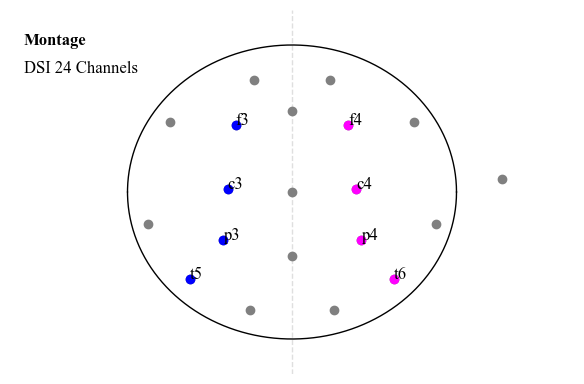

In [680]:
# Plot the electrodes used in the statistical tests
plt.figure(figsize=(6,4))
# All channels
PLOT.show_electrode(eeg_dict.ch_location, EEG.low(list(np.array(ch_setSLAP.get_labels()))), 
                    label=False, color='grey',   alpha_back=0, marker='o')
# Left channels
PLOT.show_electrode(eeg_dict.ch_location, EEG.low(list(np.array(ch_setSLAP.get_labels())[isLeft])), 
                    label=True, color='blue',    alpha_back=0, marker='o')
# Right channels
PLOT.show_electrode(eeg_dict.ch_location, EEG.low(list(np.array(ch_setSLAP.get_labels())[isRight])), 
                    label=True, color='magenta', alpha_back=0, marker='o')
# Interpolated channels
PLOT.show_electrode(eeg_dict.ch_location, EEG.low(old_ch_bads), 
                    label=False, color='lime', alpha_back=0, marker='x')
lim = 1.8
plt.xlim(-lim, lim)
plt.ylim(-1.3, 1.3)
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.text(-lim*0.95, 1.05, f'Montage', weight='bold')
split_text = montage_type.split('_')
plt.text(-lim*0.95, 0.85, f'{split_text[0]} {split_text[1]} Channels')
plt.axvline(0, lw=1, ls='--', color='grey', alpha=0.25)

# Show the boundary of the head:
r0 = 1.05
theta = np.arange(0, np.pi, 0.01)
plt.plot(r0 * np.cos(theta), r0 * np.sin(theta), color='black', lw=1)
plt.plot(r0 * np.cos(theta), -r0 * np.sin(theta), color='black', lw=1)
plt.tight_layout()
plt.show()

In [681]:
# STAT TESTS
# Generate frequency bins in each frequency band
bins_ticks = np.arange(fmin, fmax+1, int(resolution))

N = len(freq_band) - 1

In [629]:
# SAVE PSDs WITH SAME FORMAT
# 32 x 20 matrix (trial, ch)
# Trials are arranged according to the sequence [1,3,2,3] which correspond to [left, left_rest, right, right_rest]
# The 20th col corresponds to the trial labels, ch A2 is missing from the matrix

# Channels labels to keep
ch_to_keep = ['p3',  'c3', 'f3', 'fz', 'f4', 'c4', 'p4', 'cz', 'pz', 'fp1', 
              'fp2', 't3', 't5', 'o1', 'o2', 'f7', 'f8', 't6', 't4']

# Index of channel labels to keep
idx_ch_to_keep = ch_setSLAP.find_labels(ch_to_keep)
# Index of bins in alpha band
idx_alpha_band = np.where((bins_ticks >= 8) & (bins_ticks < 13))[0]

# Vectors to merge
ws = psds_left
xs = psds_left_rest
ys = psds_right
zs = psds_right_rest

# Aggregate over alpha band
ws = np.mean(ws[ :, :, idx_alpha_band ], axis=2)
xs = np.mean(xs[ :, :, idx_alpha_band ], axis=2)
ys = np.mean(ys[ :, :, idx_alpha_band ], axis=2)
zs = np.mean(zs[ :, :, idx_alpha_band ], axis=2)

# Convert to dB
ws = EEG.convert_dB(ws)
xs = EEG.convert_dB(xs)
ys = EEG.convert_dB(ys)
zs = EEG.convert_dB(zs)

# Remove not needed channels
ws = ws[ : , idx_ch_to_keep ]
xs = xs[ : , idx_ch_to_keep ]
ys = ys[ : , idx_ch_to_keep ]
zs = zs[ : , idx_ch_to_keep ]

# Initialize an empty list to hold the alternating rows
combined_list = []
label_list = []

# Loop over the rows and add them in alternating order, with labels
for i in range(8):
    combined_list.append(ws[i, :])
    label_list.append(1)  # Label for left
    combined_list.append(xs[i, :])
    label_list.append(3)  # Label for left_rest
    combined_list.append(ys[i, :])
    label_list.append(2)  # Label for right
    combined_list.append(zs[i, :])
    label_list.append(3)  # Label for right_rest

# Stack the list of arrays vertically to get a single array
combined_array = np.vstack(combined_list)
# Create a label array and reshape it to be a column
label_array = np.array(label_list).reshape(-1, 1)
# Concatenate the combined array with the label column to get the final array
final_array = np.hstack((combined_array, label_array))
print("Shape of the final array:", final_array.shape)

np.save(f'{base_name}.npy', final_array)

Shape of the final array: (32, 20)


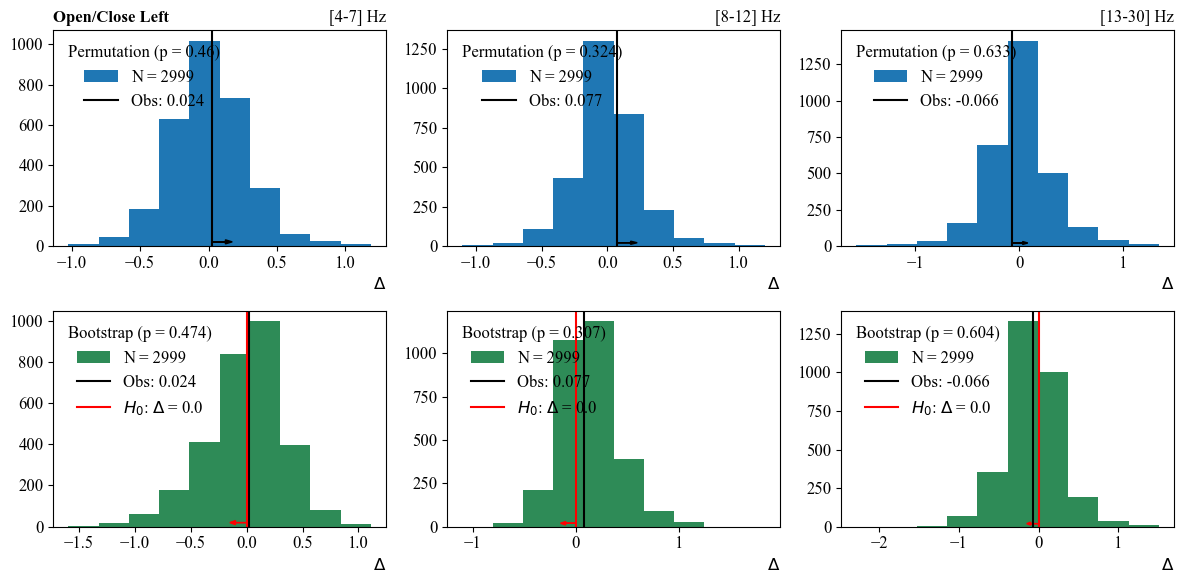

In [762]:
# Initialize useful things for the statistical test
nSim = 2999
perm_bool = True # Do Permutation test
boot_bool = True # Do Bootstrap test

r2_left = []
p_left = []
labels = []

# LEFT HAND Statistical Test begins
fig, axs = plt.subplots(nrows=2, ncols=N, figsize=(int(4*N),6))
# Generate array of trials, rest followed by task
x = np.vstack([psds_left_rest, psds_left]) #(trial, ch, bin)
# Generate labels for rest (True) and task (False)
isTreatment = np.arange(x.shape[0]) < psds_left_rest.shape[0] #(trial,)
isContralat = isRight

for i in range(len(freq_band)-1):
    STAT = mi.Stats(ch_set=ch_setSLAP, dict_symm=eeg_dict.dict_symm, isContralat=isContralat, bins=bins_ticks, custom_bins=[freq_band[i], freq_band[i+1]])
    # Average the data (PSDs) within the specified frequency bins (trial, ch, bin) -> (trial, ch)
    x_ = np.mean(x[:, :, STAT.custom_ticks[0] : STAT.custom_ticks[-1]], axis=2)
    # Transform PSDs to dB
    x_ = EEG.convert_dB(x_)
    r2_left.append(STAT.DifferenceOfR2(x_, isTreatment))
    if perm_bool:
        if i == 0: axs[0,i].set_title(r'Open/Close Left', fontsize=12,weight='bold', loc='left')
        axs[0,i].set_title(f'[{freq_band[i]}-{freq_band[i+1]-1}] Hz', fontsize=12, loc='right')
        p = STAT.ApproxPermutationTest(x=x_, isTreatment=isTreatment, stat=STAT.DifferenceOfSumsR2, nSimulations=nSim, plot=True, ax=axs[0,i])
        p_left.append(p)
        labels.append(f'{freq_band[i]}-{freq_band[i+1]-1} Hz (P)')
    if boot_bool:
        p = STAT.BootstrapTest(x=x_, isTreatment=isTreatment, stat=STAT.DifferenceOfSumsR2, nSimulations=nSim, nullHypothesisStatValue=0.0, plot=True, ax=axs[1,i])
        p_left.append(p)
        labels.append(f'{freq_band[i]}-{freq_band[i+1]-1} Hz (B)')
plt.tight_layout()
plt.show()

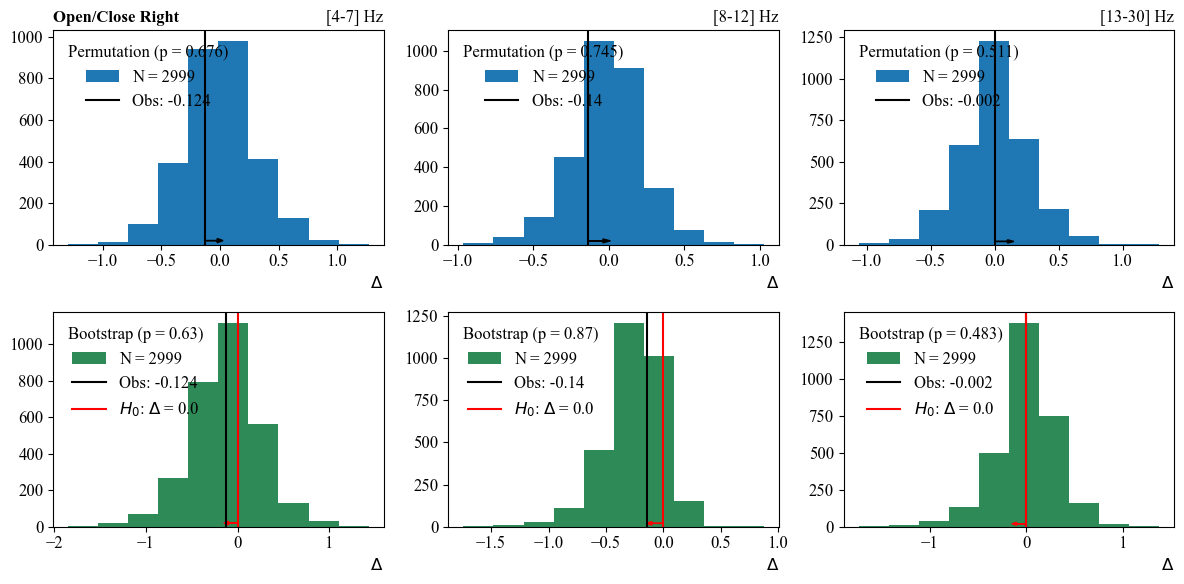

In [763]:
p_right = []
r2_right = []

# RIGHT HAND Statistical Test begins
fig, axs = plt.subplots(nrows=2, ncols=N, figsize=(int(4*N),6))
# Generate array of trials, rest followed by task
x = np.vstack([psds_right_rest, psds_right]) #(trial, ch, bin)
# Generate labels for rest (True) and task (False)
isTreatment = np.arange(x.shape[0]) < psds_right_rest.shape[0] #(trial,)
isContralat = isLeft

for i in range(len(freq_band)-1):
    STAT = mi.Stats(ch_set=ch_setSLAP, dict_symm=eeg_dict.dict_symm, isContralat=isContralat, bins=bins_ticks, custom_bins=[freq_band[i], freq_band[i+1]])
    # Average the data (PSDs) within the specified frequency bins (trial, ch, bin) -> (trial, ch)
    x_ = np.mean(x[:, :, STAT.custom_ticks[0] : STAT.custom_ticks[-1]], axis=2)
    # Transform PSDs to dB
    x_ = EEG.convert_dB(x_)
    r2_right.append(STAT.DifferenceOfR2(x_, isTreatment))
    if perm_bool:
        if i == 0: axs[0,i].set_title(r'Open/Close Right', fontsize=12,weight='bold', loc='left')
        axs[0,i].set_title(f'[{freq_band[i]}-{freq_band[i+1]-1}] Hz', fontsize=12, loc='right')
        p = STAT.ApproxPermutationTest(x=x_, isTreatment=isTreatment, stat=STAT.DifferenceOfSumsR2, nSimulations=nSim, plot=True, ax=axs[0,i])
        p_right.append(p)
    if boot_bool:
        p = STAT.BootstrapTest(x=x_, isTreatment=isTreatment, stat=STAT.DifferenceOfSumsR2, nSimulations=nSim, nullHypothesisStatValue=0.0, plot=True, ax=axs[1,i])
        p_right.append(p)
plt.tight_layout()
plt.show()

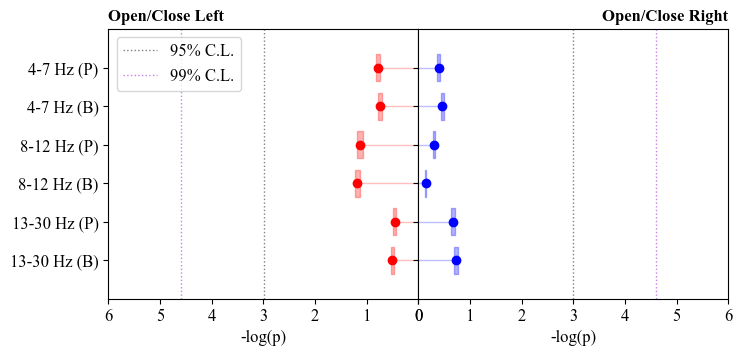

In [764]:
# Plot p-values extracted by Statistical tests
# This is a Left - Right view
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)
y_max = 0.5
y_min = -0.5
y = np.linspace(start=y_max, stop=y_min, num=len(p_left)+2)
y = y[1:-1]
deltay = 0.05
# Left results
#---------
x_values = []
xUp_values = []
xDown_values = []
for p in p_left:
    p_down, p, p_up = STAT.pvalue_interval(p, nSim+1)
    xUp_values.append(STAT.negP(p_up))
    x_values.append(STAT.negP(p))
    xDown_values.append(STAT.negP(p_down))
#---------
ax1.set_title('Open/Close Left', fontsize=12, loc='left', weight='bold')
ax1.scatter(x_values, y, color='red', marker='o')
# Add confidence interval on true p
for i in range(len(y)):
    ax1.fill_betweenx([y[i]-deltay, y[i]+deltay], xDown_values[i], xUp_values[i], color='red', alpha=0.3)
ax1.hlines(y, 0, x_values, colors='red', lw=1, alpha=0.25)
ax1.set_xlabel(r'-log(p)')
ax1.set_xlim(ax1.get_xlim()[::-1])  # Reverse the x-axis for left plot
ax1.set_xlim(right=0, left=6)
ax1.set_ylim(y_min, y_max)
ax1.axvline(STAT.negP(0.05), color='black', lw=1, ls=':', alpha=0.5, label='95% C.L.')
ax1.axvline(STAT.negP(0.01), color='darkviolet', lw=1, ls=':', alpha=0.5, label='99% C.L.')
ax1.set_yticks(y)
ax1.set_yticklabels(labels)
ax1.legend(loc='upper left')
# Right results
#---------
x_values = []
xUp_values = []
xDown_values = []
for p in p_right:
    p_down, p, p_up = STAT.pvalue_interval(p, nSim+1)
    xUp_values.append(STAT.negP(p_up))
    x_values.append(STAT.negP(p))
    xDown_values.append(STAT.negP(p_down))
#---------
ax2.set_title('Open/Close Right', fontsize=12, loc='right', weight='bold')
ax2.scatter(x_values, y, color='blue', marker='o')
# Add confidence interval on true p
for i in range(len(y)):
    ax2.fill_betweenx([y[i]-deltay, y[i]+deltay], xDown_values[i], xUp_values[i], color='blue', alpha=0.3)
ax2.hlines(y, 0, x_values, colors='blue', lw=1, alpha=0.25)
ax2.set_xlabel(r'-log(p)')
ax2.set_xlim(left=0, right=6)
ax1.set_ylim(y_min, y_max)
ax2.axvline(STAT.negP(0.05), color='black', lw=1, ls=':', alpha=0.5)
ax2.axvline(STAT.negP(0.01), color='darkviolet', lw=1, ls=':', alpha=0.5)
#--------- 
plt.subplots_adjust(wspace=0)  # Adjust space between subplots
plt.show()

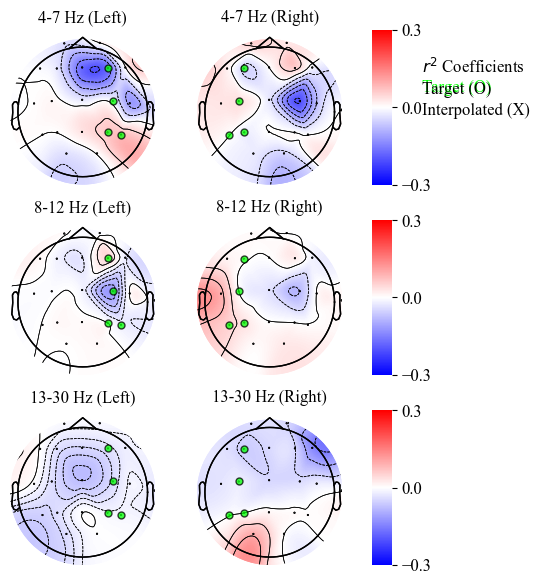

In [657]:
# Plot topoplots with r2
# Identify interpolated channels to show on the topomap
mask = np.array([True if x in old_ch_bads else False for x in ch_setSLAP.get_labels()])
mask_params1 = dict(marker='X', markersize=6, markerfacecolor='black')
# Identify target channels to show on the topomap
mask_right = np.array([True if x in isLeft_ch else False for x in ch_setSLAP.get_labels()])
mask_left = np.array([True if x in isRight_ch else False for x in ch_setSLAP.get_labels()])
mask_params2 = dict(marker='o', markersize=5, markerfacecolor='lime', alpha=0.75)
# Plot
fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(6, int(2*N)))
# Make colormap for topoplots
custom_cmap = PLOT.make_simple_cmap('blue', 'white', 'red')

for i in range(N):
    if i==0: 
        PLOT.plot_topomap_L_R([axes[i,0],axes[i,1],axes[i,2]], RAW_SL, r2_left[i], r2_right[i], custom_cmap, (-0.3, 0.3), 
                              [mask,mask_left,mask_right], [mask_params1,mask_params2], text=True)
    else: 
        PLOT.plot_topomap_L_R([axes[i,0],axes[i,1],axes[i,2]], RAW_SL, r2_left[i], r2_right[i], custom_cmap, (-0.3, 0.3), 
                              [mask,mask_left,mask_right], [mask_params1,mask_params2], text=False)
    
    if p_left[1::2][i] < 0.05:
        axes[i,0].set_title(f'*{freq_band[i]}-{freq_band[i+1]-1} Hz (Left)', fontsize=12)
    else: 
        axes[i,0].set_title(f'{freq_band[i]}-{freq_band[i+1]-1} Hz (Left)', fontsize=12)
        
    if p_right[1::2][i] < 0.05:
        axes[i,1].set_title(f'*{freq_band[i]}-{freq_band[i+1]-1} Hz (Right)', fontsize=12)
    else: 
        axes[i,1].set_title(f'{freq_band[i]}-{freq_band[i+1]-1} Hz (Right)', fontsize=12)

fig.tight_layout()
plt.show()

In [658]:
# Generate array of trials, rest followed by task
x_list = [np.vstack([psds_left_rest, psds_left]),   #(trial, ch, bin)]
          np.vstack([psds_right_rest, psds_right])] #(trial, ch, bin)]

# Generate labels for rest (True) and task (False)
isTreatment_list = [np.arange(x_list[0].shape[0]) < psds_left_rest.shape[0],  #(trial,)
                    np.arange(x_list[1].shape[0]) < psds_right_rest.shape[0]] #(trial,)

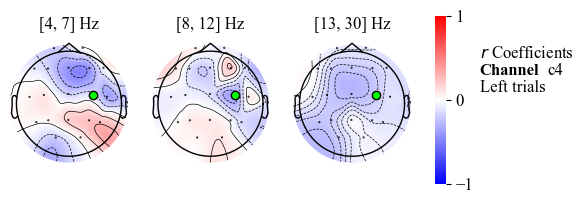

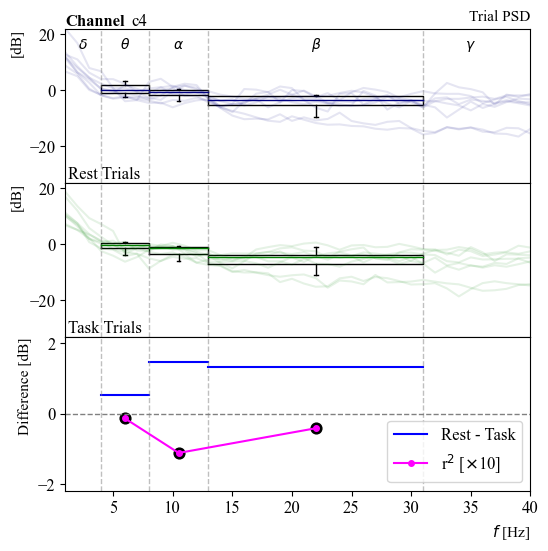

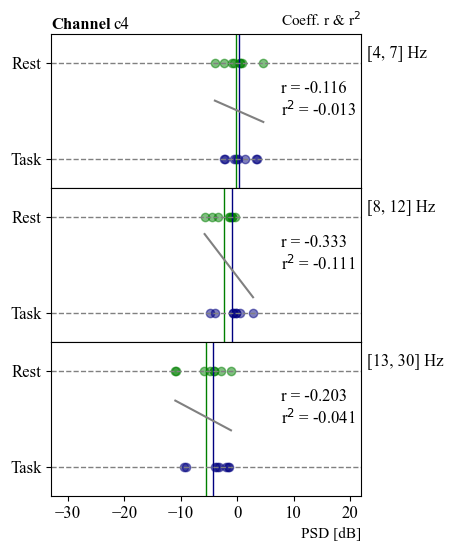

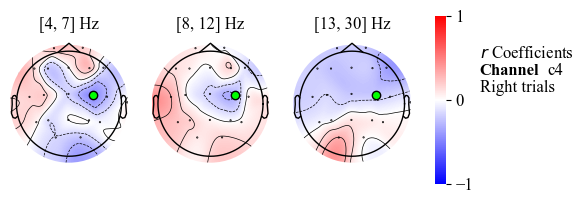

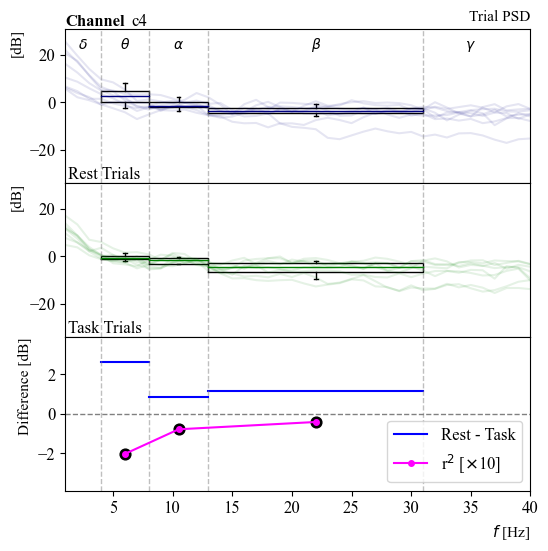

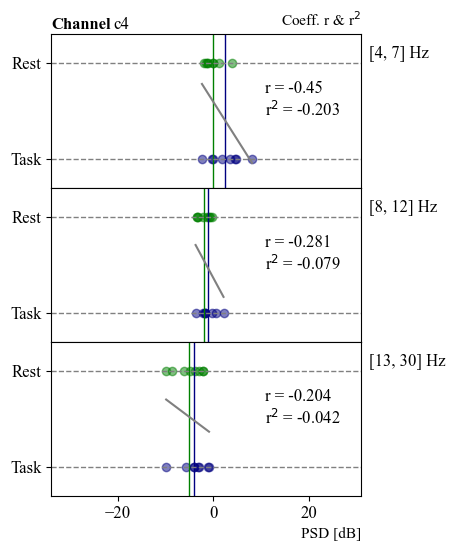

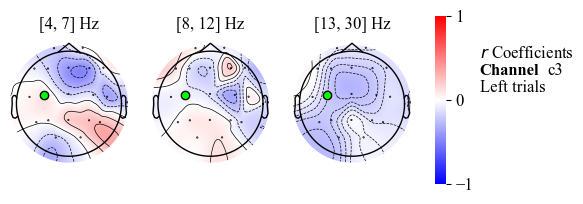

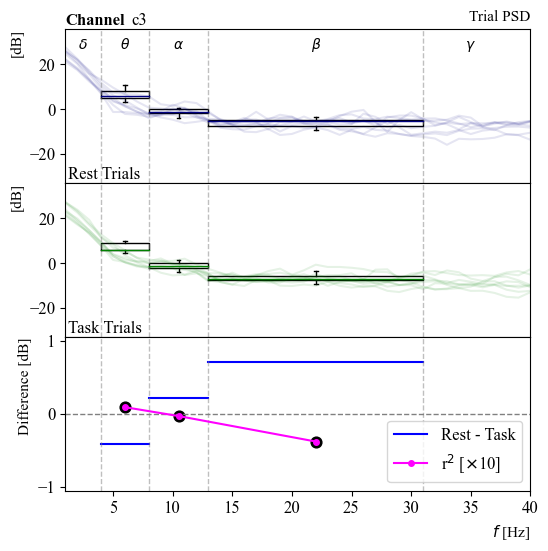

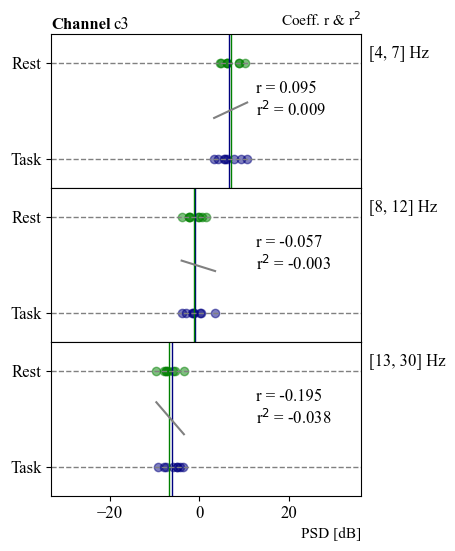

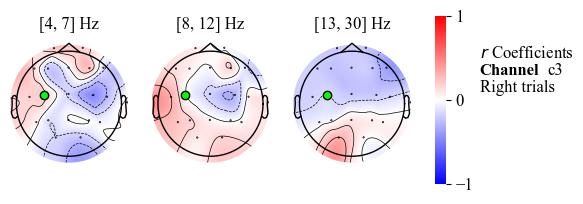

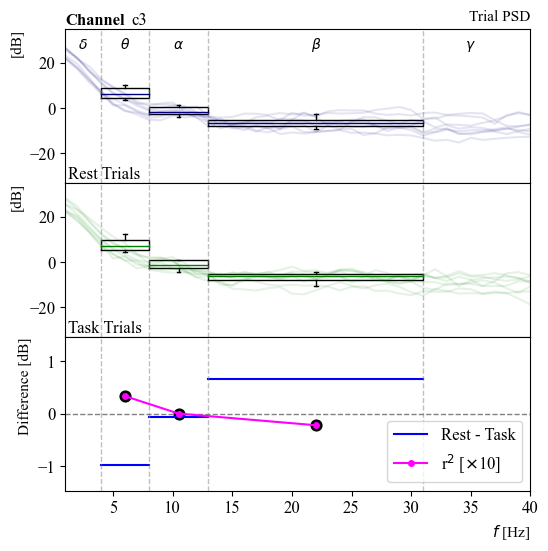

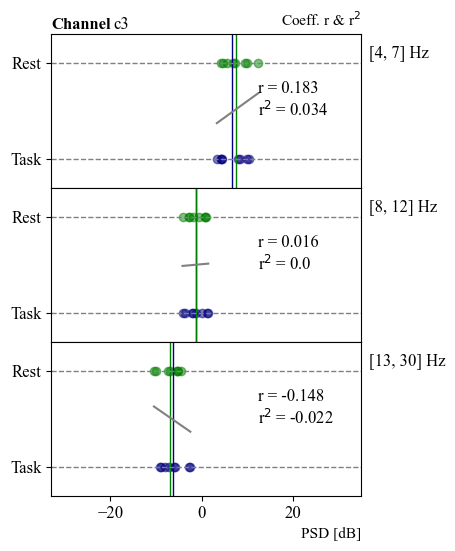

In [659]:
# List of channels to show plots for
chs = ['c4', 'c3']
# Find symmetric channel id
#ch_symm = EEG.find_ch_symmetry(ch_location=eeg_dict.ch_location, ch_list=[ch.lower()])[ch.lower()]
#ch_symm_idx = ch_set.find_labels(ch_symm)[0]

for ch in chs:
    # Find channel id
    ch_idx = ch_set.find_labels(ch)[0]
    
    # xlim to use in plots based on frequency range used
    xlim = [STAT.bins[0], STAT.bins[-1]]

    # Masks for target electrodes
    mask = np.array([True if x==ch else False for x in ch_setSLAP.get_labels()])
    mask_params = dict(marker='o', markersize=6, markerfacecolor='lime')

    # Define mid points and width of frequency bands to consider
    x_band = []
    w_band = []
    for i in range(N):
        # Frequency bands mid points
        x_band.append(freq_band[i] + (freq_band[i+1] - freq_band[i]) / 2)
        # Frequency bands width
        w_band.append( freq_band[i+1] - freq_band[i])
        
    # Generate plots for Left and Right trials
    for k, mode in enumerate(['Left', 'Right']):
        # Generate the canvases
        figTopo, axsTopo = plt.subplots(1, N+1, figsize=(int(2*N+1), 2)) # Canvas for topoplots
        figPSD,  axsPSD  = plt.subplots(3, 1,   figsize=(6, int(2*(3)))) # Canvas for PSDs
        figCorr, axsCorr = plt.subplots(N, 1,   figsize=(4, int(2*N)))   # Canvas for correlation coeffs

        # Define which trials to consider
        x = x_list[k]
        isTreatment = isTreatment_list[k]

        # Rest PSD trials
        xs, y_rest, ws = PLOT.plot_psd_at_channel(x=x[ :, [ch_idx], : ][ isTreatment], color='navy', ax=axsPSD[0], freq_band=freq_band, bins=STAT.bins)
        # Use Rest PSD trials to define y limits in dB
        ylim = (int(np.min(y_rest) - np.abs(np.min(y_rest)) - 15), 
                int(np.max(y_rest) + np.abs(np.max(y_rest)) + 15))\
        # Plot (Rest PSD trials)
        PLOT.plot_frequency_bands(ax=axsPSD[0], ylim=ylim, fontsize=10)
        axsPSD[0].set_xticks([])
        axsPSD[0].set_xlim(xlim)
        axsPSD[0].set_ylim(ylim)
        axsPSD[0].set_ylabel('[dB]', loc='top', fontsize=11)
        axsPSD[0].text(xlim[0]+0.25, ylim[0] + (ylim[1]-ylim[0])*0.025, 'Rest Trials')
    
        # Lists to store information for each frequency band
        ys = []
        r_coeffs = []
        cmap_max=1

        # Generate plots for each frequency band
        for i in range(N):
            idx = np.where((STAT.bins >= freq_band[i]) & (STAT.bins < freq_band[i+1]))[0]
            start_idx = idx[0]
            end_idx = idx[-1]
            x_within_band = np.mean(x[:, :, start_idx:end_idx], axis=2) #(trial, ch)
            x_within_band = EEG.convert_dB(x_within_band) # Transform PSDs to dB
            r_coeff = STAT.CalculateR(x=x_within_band, isTreatment=isTreatment)
            r_coeffs.append(r_coeff)
            ys.append(r_coeff[ [ch_idx] ])

            # Band r topoplot
            mne.viz.plot_topomap(r_coeff, RAW_SL.info, ch_type='eeg', sensors=True, cmap=PLOT.simple_cmap, vlim=(-cmap_max,cmap_max), 
                                 mask=mask, mask_params=mask_params, show=False, axes=axsTopo[i])
            
            # Convert labels of trials into dummy variable (True/Rest = 1, False/Task = 0 by choice)
            dummy = STAT.Dummy(isTreatment)
            PLOT.plot_correlation_psd_groups(x=x_within_band[ :, [ch_idx] ], y=dummy, isTreatment=isTreatment, r=r_coeff[ [ch_idx] ], xlim=ylim, ax=axsCorr[i])
            
            # Show frequency band (topoplot)
            axsTopo[i].set_title(f'[{freq_band[i]}, {freq_band[i+1]-1}] Hz', fontsize=12)
            
            # Show frequency band (correlation)
            axsCorr[i].text(ylim[-1] + np.abs(ylim[-1])*0.05, 1.05, f'[{freq_band[i]}, {freq_band[i+1]-1}] Hz', fontsize=12)
            axsCorr[i].set_xlim(ylim)
            if i != N-1: 
                axsCorr[i].set_xticks([])
                
        # Task PSD trials
        xs, y_task, ws = PLOT.plot_psd_at_channel(x=x[ :, [ch_idx], : ][~isTreatment], color='green', ax=axsPSD[1], freq_band=freq_band, bins=STAT.bins)
        # Plot (Task PSD trials)
        PLOT.plot_frequency_bands(ax=axsPSD[1], ylim=None)
        axsPSD[1].set_xticks([])
        axsPSD[1].set_xlim(xlim)
        axsPSD[1].set_ylim(ylim)
        axsPSD[1].set_ylabel('[dB]', loc='top', fontsize=11)
        axsPSD[1].text(xlim[0]+0.25, ylim[0] + (ylim[1]-ylim[0])*0.025, 'Task Trials')

        # Rest - Task PSD (mean) trials
        y_diff = [np.mean(i)-np.mean(j) for i,j in zip(y_rest, y_task)]
        ymax = int(np.max(np.abs(y_diff)) * 2)
        # Plot (Rest - Task PSD (mean) trials)
        for i,y in enumerate(y_diff):
            if i==0: 
                axsPSD[2].plot([x_band[i]-w_band[i]/2, x_band[i]+w_band[i]/2], [y,y], color='blue', label='Rest - Task')
            else:
                axsPSD[2].plot([x_band[i]-w_band[i]/2, x_band[i]+w_band[i]/2], [y,y], color='blue')
        axsPSD[2].axhline(0, lw=1, ls='--', color='grey')
        axsPSD[2].set_xlim(xlim)
        axsPSD[2].set_xlabel('$f$ [Hz]', loc='right', fontsize=11)
        ylim_diff = np.max(np.abs(y_diff))*1.5
        axsPSD[2].set_ylim(-ylim_diff, ylim_diff)
        axsPSD[2].set_ylabel('Difference [dB]', fontsize=11, loc='top')
        PLOT.plot_frequency_bands(ax=axsPSD[2], ylim=None)
        # Add r2 on top of PSD difference
        ys =  [x * abs(x) * 10 for x in ys]
        color='magenta'
        axsPSD[2].plot(x_band, ys, '-o', color=color, markersize=4, label=r'r$^{2}$ [$\times$10]')
        axsPSD[2].scatter(x_band, ys, color='black', s=60)
        axsPSD[2].legend(loc='lower right', frameon=True)
        # Add new axis on the right
        #ax = axsPSD[2].twinx()  # instantiate a second axes that shares the same x-axis
        #ax.set_ylabel(r'[$\times$10]  r$^{2}$', color=color)  # we already handled the x-label with ax1
        #ax.tick_params(axis='y', labelcolor=color, color=color)
        #ax.set_ylim(-1,1)

        # Show channel (correlation)
        axsCorr[0].text(ylim[0], 1.35, 'Channel', weight='bold', fontsize=12)
        axsCorr[0].text(ylim[0] + np.abs(ylim[1]-ylim[0])*0.2, 1.35, f'{ch}',fontsize=12)
        axsCorr[0].set_title(r'Coeff. r & r$^{2}$', fontsize=11, loc='right')
        
        # Show channel (PSD)
        axsPSD[0].text(xlim[0], ylim[-1] + np.abs(ylim[-1])*0.05, f'Channel', weight='bold', fontsize=12)
        axsPSD[0].text(xlim[0] + 5.5, ylim[-1] + np.abs(ylim[-1])*0.05, f'{ch}', fontsize=12)
        axsPSD[0].set_title('Trial PSD', fontsize=11, loc='right')
        
        # Add color bar (topoplot)
        clim = dict(kind='value', lims=[-cmap_max,0,cmap_max])
        divider = make_axes_locatable(axsTopo[-1])
        axsTopo[-1].set_yticks([])
        axsTopo[-1].set_xticks([])
        axsTopo[-1].axis('off')
        axsTopo[-1] = divider.append_axes(position='left', size='20%', pad=0.5)
        mne.viz.plot_brain_colorbar(axsTopo[-1], clim=clim, colormap=PLOT.simple_cmap, transparent=False, orientation='vertical', label=None)   
        axsTopo[-1].text(4,  0.5, r'$r$ Coefficients', fontsize=12)
        axsTopo[-1].text(4,  0.3, f'Channel', weight='bold', fontsize=12)
        axsTopo[-1].text(10, 0.3, f'{ch}', fontsize=12)
        axsTopo[-1].text(4,  0.1, f'{mode} trials', fontsize=12)
        
        figCorr.subplots_adjust(hspace=0)
        figPSD.subplots_adjust(hspace=0)

        # plt.savefig()
        # plt.savefig()

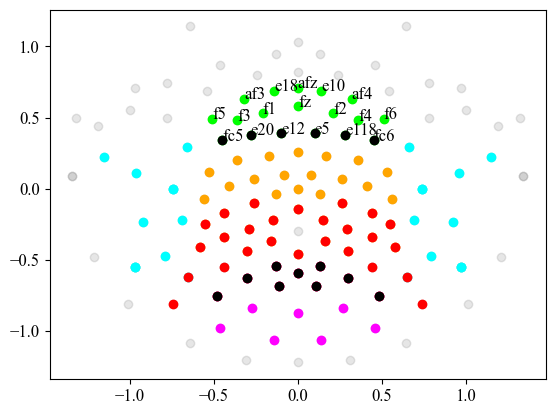

In [386]:
PLOT.show_electrode(eeg_dict.ch_location, ch_list=None,         color='grey',    label=False,  alpha_back=0.1, alpha=0.1)
#PLOT.show_electrode(eeg_dict.ch_location, ch_list=eeg_dict.ch_forehead,           color='red',     label=False, alpha_back=0)
#PLOT.show_electrode(eeg_dict.ch_location, ch_list=eeg_dict.ch_face,               color='blue',    label=False, alpha_back=0)
PLOT.show_electrode(eeg_dict.ch_location, ch_list=eeg_dict.ch_frontal,            color='lime',    label=True, alpha_back=0)
PLOT.show_electrode(eeg_dict.ch_location, ch_list=eeg_dict.ch_central,            color='orange',  label=False, alpha_back=0)
PLOT.show_electrode(eeg_dict.ch_location, ch_list=eeg_dict.ch_frontal_central,    color='black',   label=False, alpha_back=0)        
PLOT.show_electrode(eeg_dict.ch_location, ch_list=eeg_dict.ch_temporal,           color='aqua',    label=False, alpha_back=0)
PLOT.show_electrode(eeg_dict.ch_location, ch_list=eeg_dict.ch_occipital,          color='magenta', label=False, alpha_back=0)
PLOT.show_electrode(eeg_dict.ch_location, ch_list=eeg_dict.ch_parietal,           color='red',     label=False, alpha_back=0)
PLOT.show_electrode(eeg_dict.ch_location, ch_list=eeg_dict.ch_parietal_occipital, color='black',   label=False, alpha_back=0)

In [ ]:
def L1(x1=None, x2=None):
    # Manhattan
    return np.sum(np.abs(x1 - x2))

def L2(x1=None, x2=None):
    # Euclidean
    return np.sqrt(np.sum((x1 - x2) ** 2))

def Lp(x1=None, x2=None, p=4):
    # Minkovski (generalizes Euclidean)
    return np.sum(np.abs(x1 - x2) ** p) ** (1/p)

def Linf(x1=None, x2=None):
    # Chebishev
    return np.max(np.abs(x1 - x2))

def distance_matrix(x=None, distance=L2):
    n = x.shape[0]
    d = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j >= i: d[i,j] = distance(x[i], x[j])
            else: d[i,j] = d[j,i]
    return d

def gaussian(x, sigma):
    return np.exp(-x**2 / (2 * sigma**2)) / (sigma * np.sqrt(2*np.pi))

def gauss_affinity(d, sigma, neg=False):
    n = d.shape[0]
    a = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            a[i,j] = gaussian(d[i,j], sigma)
        
    for i in range(n):
        a[i,:] /= np.sum(a[i,:])
            
    if neg: 
        for i in range(n): 
            a[i,i] = 0
    return a

In [ ]:
x = [0,  0.5,  -0.5,   0.75, 0,   -0.75]
y = [0, -0.25, -0.25, -0.5, -0.5, -0.5 ]
X = np.array([x,
              y])

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(distance_matrix(X))
plt.subplot(142)
plt.imshow(gauss_affinity(d2(X), 0.04))
plt.subplot(143)
plt.imshow(gauss_affinity(d2(X), 0.20, neg=True))
plt.subplot(144)
plt.imshow(gauss_affinity(d2(X), 0.04) - gauss_affinity(d2(X), 0.20, neg=True))
plt.show()

In [ ]:
## Test with Jeremy library

In [ ]:
import PermutationVsBootstrap as pb

In [ ]:
x = np.random.normal(0,1,100)
isTreatment = np.arange(len(x)) < len(x)//3

In [ ]:
case1 = []
case2 = []

for i in range(100):
    case1.append(pb.BootstrapTest(x,
                                  isTreatment,
                                  stat=pb.DifferenceOfGroupMeans,
                                  nSimulations=1999))


    #case2.append(MI.BootstrapTest(x,
    case2.append(MI.ApproxPermutationTest(x,
                                          isTreatment,
                                          stat=pb.DifferenceOfGroupMeans,
                                          nSimulations=1999))

In [ ]:
plt.scatter(case1, case2)

In [ ]:
## Markhov chain predictions

In [ ]:
# States: Sunny, Rainy, Cloudy
states = ['Sunny', 'Rainy', 'Cloudy']

# Transition Matrix
transition_matrix = np.array([[0.8, 0.1, 0.1],  # From Sunny to [Sunny, Rainy, Cloudy]
                              [0.4, 0.4, 0.2],  # From Rainy to [Sunny, Rainy, Cloudy]
                              [0.2, 0.3, 0.5]]) # From Cloudy to [Sunny, Rainy, Cloudy]

def simulate_weather(days, initial_state):
    # Make sure initial_state is valid
    if initial_state not in states:
        return "Invalid initial state."
    
    # Initial state index
    current_state_idx = states.index(initial_state)
    weather_simulation = [initial_state]
    
    for _ in range(days - 1):
        current_state_idx = np.random.choice([0, 1, 2], p=transition_matrix[current_state_idx])
        weather_simulation.append(states[current_state_idx])
    
    return weather_simulation

# Simulate weather for 10 days, starting from 'Sunny'
N = 100000
simulation_result = np.array(simulate_weather(N, 'Sunny'))
p1 = np.sum(simulation_result=='Sunny')/N
p2 = np.sum(simulation_result=='Rainy')/N
p3 = np.sum(simulation_result=='Cloudy')/N
p  = p1 + p2 + p3 
print(f"P(Sunny): {p1}")
print(f"P(Rainy): {p2}")
print(f"P(Cloudy):{p3}")
print(f"P: {p}")
#print("Weather simulation starting from Sunny:", simulation_result)